In [20]:

import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('/content/drive/MyDrive/all_faults.csv')

# Segmenting the Vibration signal into small portions using a window

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=700
stride=500

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [23]:
X.shape

(5552, 700)

# Splitting the data into Train and Test

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


# Visulaizing the data using t-sne before using Auto-Encoders

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5552 samples in 0.003s...
[t-SNE] Computed neighbors for 5552 samples in 4.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5552
[t-SNE] Computed conditional probabilities for sample 2000 / 5552
[t-SNE] Computed conditional probabilities for sample 3000 / 5552
[t-SNE] Computed conditional probabilities for sample 4000 / 5552
[t-SNE] Computed conditional probabilities for sample 5000 / 5552
[t-SNE] Computed conditional probabilities for sample 5552 / 5552
[t-SNE] Mean sigma: 1.313276
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.144012
[t-SNE] KL divergence after 300 iterations: 3.493699


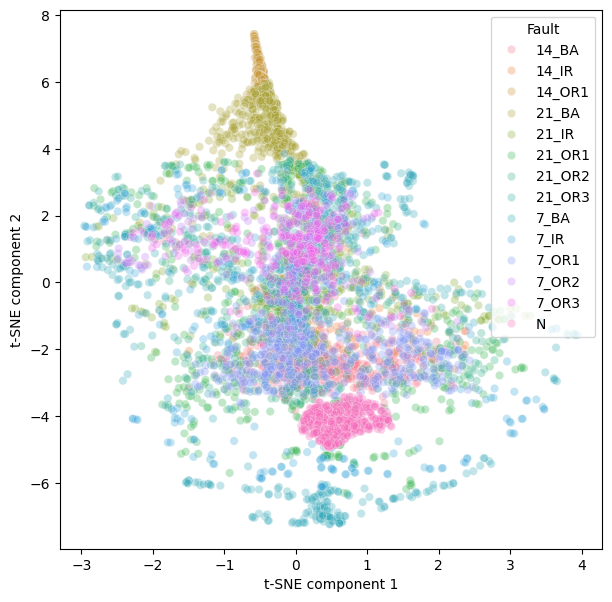

In [25]:
X_pre_aen = X

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [26]:
tSNEdf

,t-SNE component 1,t-SNE component 2,Fault
0,0.262257,-2.392496,14_BA
1,0.399595,-2.328167,14_BA
2,-0.613284,-1.709886,14_BA
3,-0.068515,-3.046363,14_BA
4,1.104280,-3.009797,14_BA
...,...,...,...
5547,0.817219,-4.294300,N
5548,1.115454,-4.090941,N
5549,0.335486,-4.020400,N
5550,0.125261,-4.423666,N


In [27]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten


# from tensorflow.keras.models import load_model
# AE_model = load_model(r'Trained Model\AE_model_gear.h5')


no_classes=len(encoder.classes_)
# build a model
model = Sequential()
model.add(Dense(1024, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 1024)                │         717,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,408,654 (5.37 MB)

 Trainable params: 1,408,654 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train,
                    y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - accuracy: 0.1603 - loss: 2.3693 - val_accuracy: 0.3289 - val_loss: 1.8420
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3987 - loss: 1.6604 - val_accuracy: 0.5546 - val_loss: 1.3869
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6013 - loss: 1.2258 - val_accuracy: 0.6315 - val_loss: 1.0831
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7120 - loss: 0.9122 - val_accuracy: 0.7119 - val_loss: 0.8899
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7910 - loss: 0.7141 - val_accuracy: 0.8169 - val_loss: 0.7007
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8833 - loss: 0.5347 - val_accuracy: 0.8271 - val_loss: 0.5560
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8970 - loss: 0.3635 - val_accuracy: 0.8427 - val_loss: 0.4946
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9088 - loss: 0.3017 - val_accuracy: 0.8181 - val_loss: 0.5884

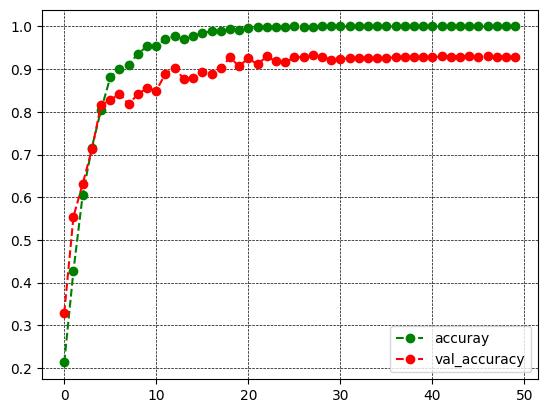

In [29]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


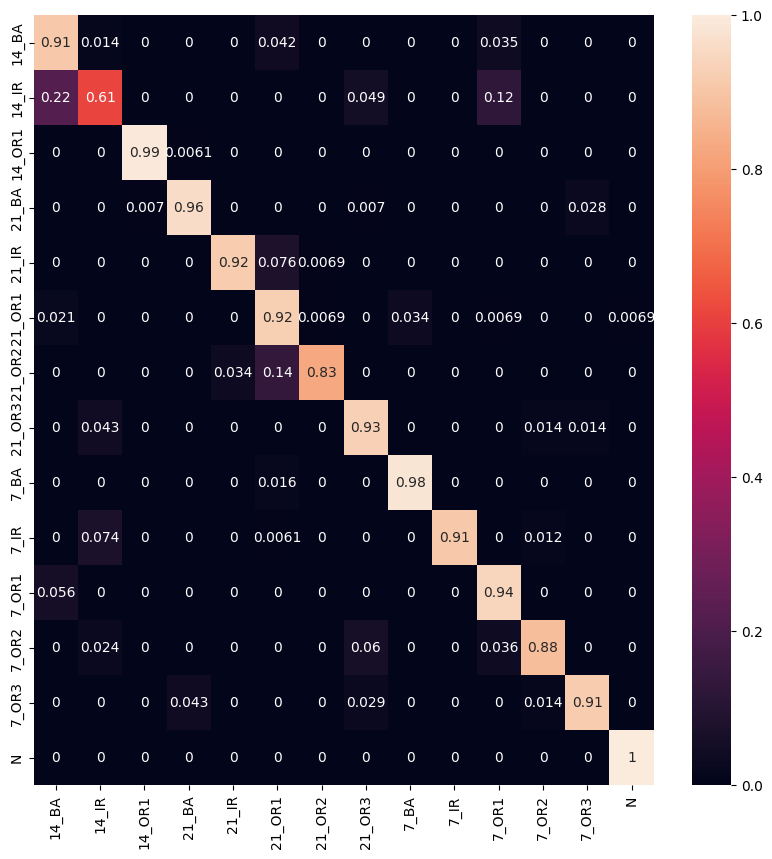

In [30]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [31]:
dummy_ann = Model(inputs=model.inputs, outputs=model.layers[-2].output) # Change model.input to model.inputs
y_viz = dummy_ann.predict(X_train)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [32]:
y_viz.shape

(3886, 128)

In [33]:
def T_SNE_plot(X_train,y_train,model,encoder):

    # Change model.input to model.inputs
    dummy_ann = Model(inputs=model.inputs,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)

    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3886 samples in 0.001s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 3886 samples in 0.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3886
[t-SNE] Computed conditional probabilities for sample 2000 / 3886
[t-SNE] Computed conditional probabilities for sample 3000 / 3886
[t-SNE] Computed conditional probabilities for sample 3886 / 3886
[t-SNE] Mean sigma: 2.971950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.311226
[t-SNE] KL divergence after 300 iterations: 1.433652


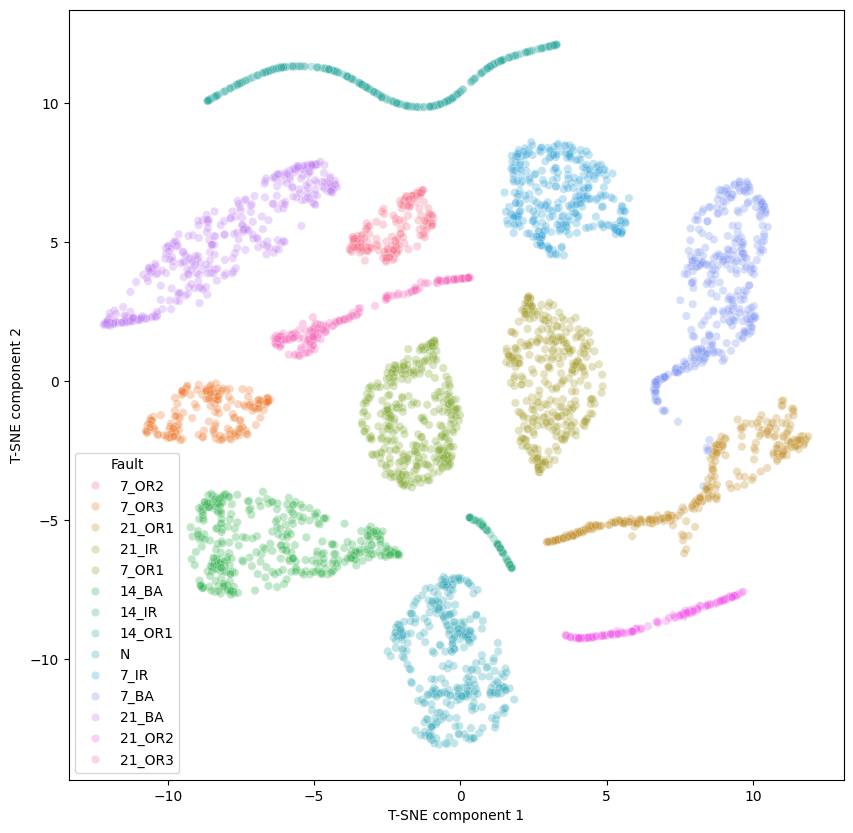

In [34]:
T_SNE_plot(X_train,y_train,model,encoder)

In [35]:
def Test_model_diff_loading(load,win_len,stride,model):

    df = pd.read_csv('/content/drive/MyDrive/all_faults.csv'.format(load))

#     win_len=1000
#     stride=200

    X=[]
    Y=[]


    for k in df['fault'].unique():

        df_temp_2 = df[df['fault']==k]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            temp = df_temp_2.iloc[i:i+win_len,:-1].values
            temp = temp.reshape((1,-1))
            X.append(temp)
            Y.append(df_temp_2.iloc[i+win_len,-1])

    X=np.array(X)
    X=X.reshape((X.shape[0],win_len))



    Y=np.array(Y)
    encoder2= LabelEncoder()
    encoder2.fit(Y)
    encoded_Y = encoder2.transform(Y)
    OHE_Y = to_categorical(encoded_Y)


    def inv_Transform_result(y_pred,encoder):
        y_pred = y_pred.argmax(axis=1)
        y_pred = encoder.inverse_transform(y_pred)
        return y_pred



    y_pred=model.predict(X)

    print('Accuracy on Load-{}hp data is---{}%'.format(load,(model.evaluate(X,OHE_Y)[1])*100))


    Y_pred=inv_Transform_result(y_pred,encoder2)
    Y_test = Y

    from sklearn.metrics import confusion_matrix


    plt.figure(figsize=(10,10))
    cm = confusion_matrix(Y_test, Y_pred,normalize='true')
    f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.show()
    print()

    T_SNE_plot(X[::10,:],OHE_Y[::10,:],model,encoder2)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9756 - loss: 0.0986
Accuracy on Load-1hp data is---97.83861637115479%


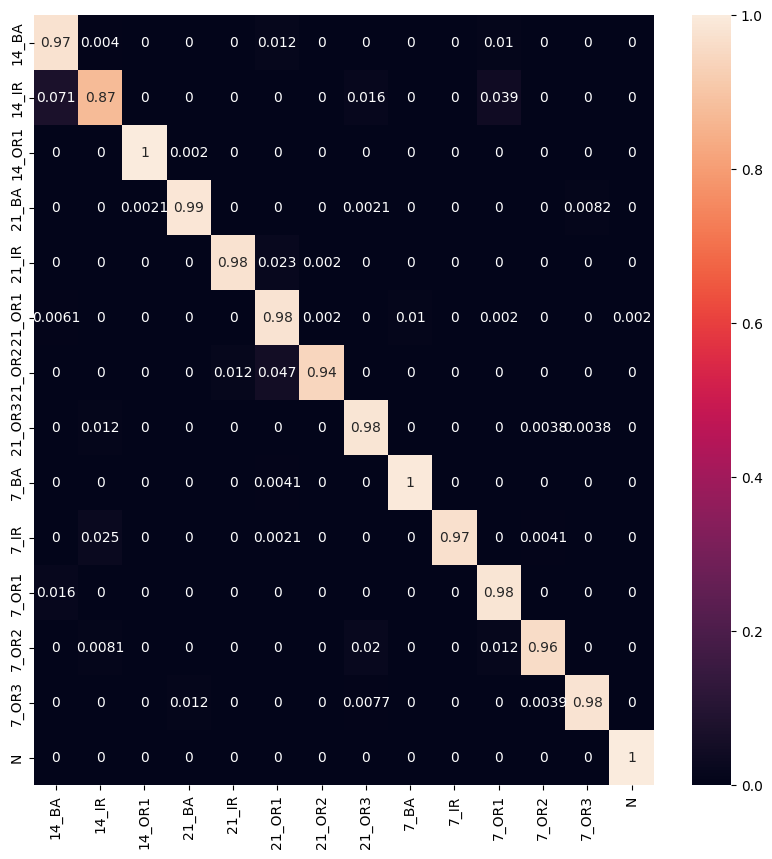


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 556 samples in 0.001s...
[t-SNE] Computed neighbors for 556 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 556 / 556
[t-SNE] Mean sigma: 8.844699


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.773022
[t-SNE] KL divergence after 300 iterations: 0.237523


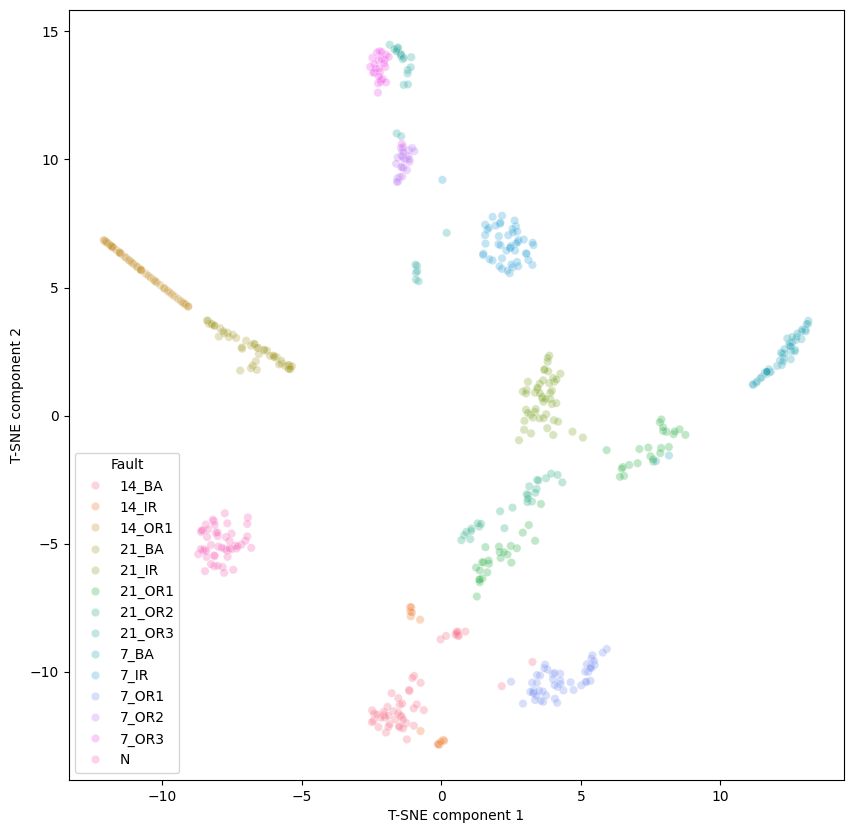

In [37]:
Test_model_diff_loading(load=1,win_len=700,stride=500,model=model)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9756 - loss: 0.0986
Accuracy on Load-2hp data is---97.83861637115479%


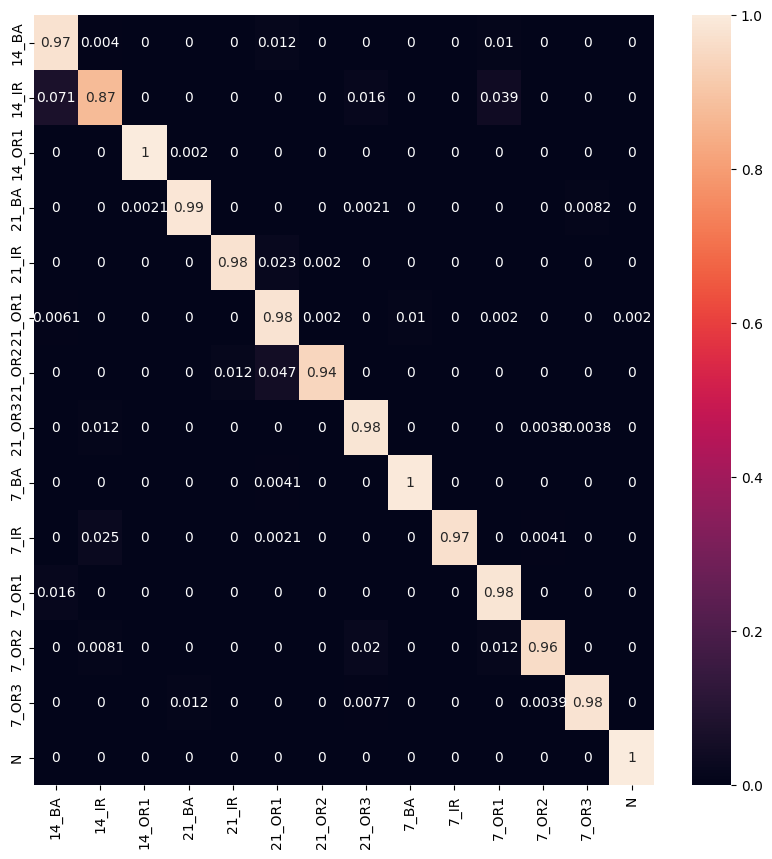


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 556 samples in 0.001s...
[t-SNE] Computed neighbors for 556 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 556 / 556
[t-SNE] Mean sigma: 8.844699


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.784801
[t-SNE] KL divergence after 300 iterations: 0.238348


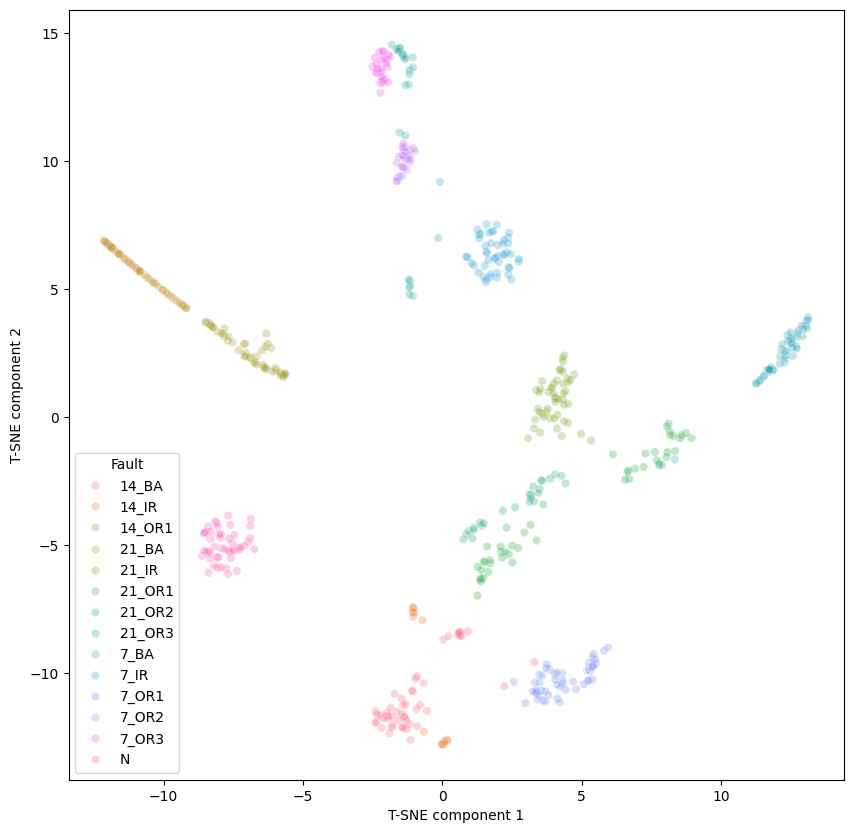

In [38]:
Test_model_diff_loading(load=2,win_len=700,stride=500,model=model)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0986
Accuracy on Load-3hp data is---97.83861637115479%


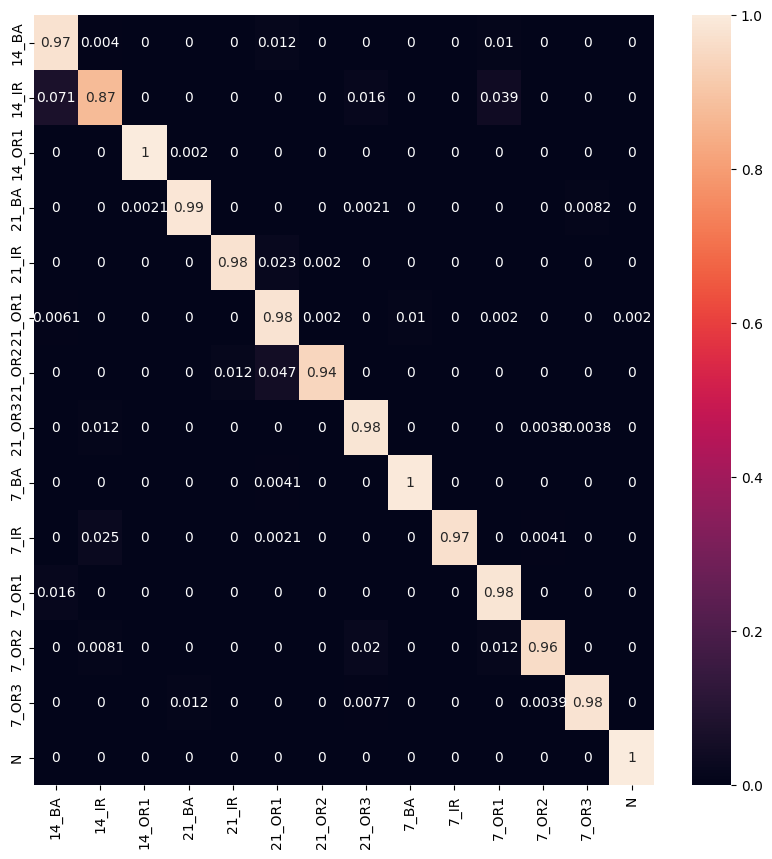


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 556 samples in 0.001s...
[t-SNE] Computed neighbors for 556 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 556 / 556
[t-SNE] Mean sigma: 8.844699
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.788990
[t-SNE] KL divergence after 300 iterations: 0.238467


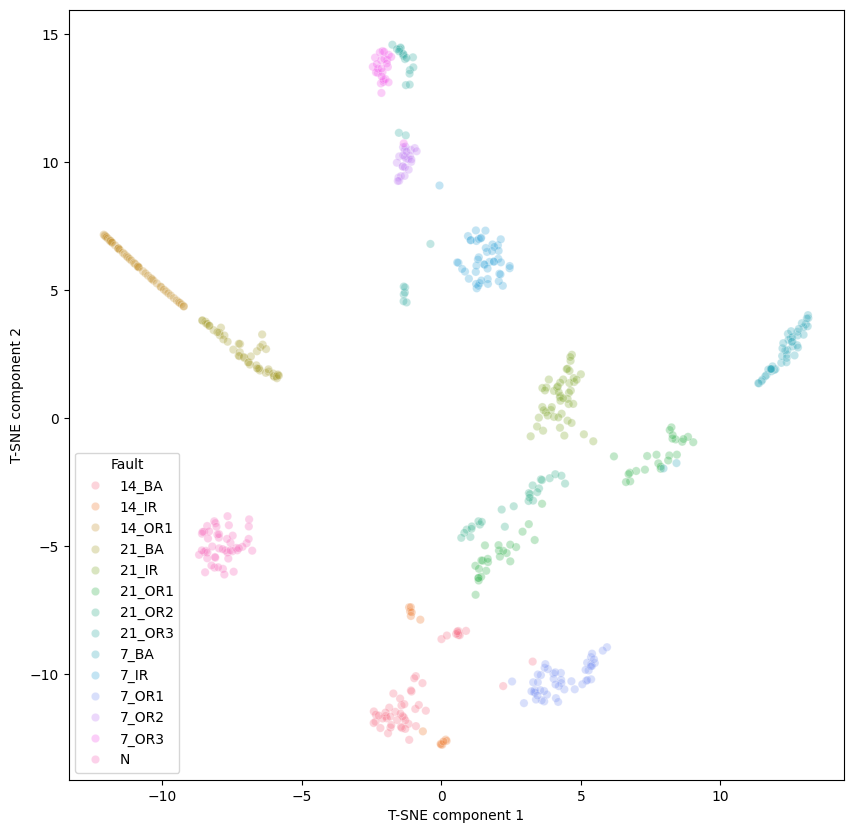

In [39]:
Test_model_diff_loading(load=3,win_len=700,stride=500,model=model)